### Restuarants in London

### Capstone Project - The Battle of Neighborhoods

#### Source Code

##### IMPORT DEPENDENCIES

In [1]:
!pip -q install folium
print('folium installed...')
import folium 
print('folium imported...')

#library to handle data in a vectorized manner
import numpy as np
print('numpy imported...')

#library for data analysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('pandas imported...')

#library to handle JSON file
import json
print('json imported...')

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
print('geopy installed...')
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

# library to handle request
import requests
print('requests imported...')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib imported...')

# transform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('json_normalize imported...')

# library used for data visualization
import seaborn as sns
print('seaborn imported...')

# import k-means from clustering stage
from sklearn.cluster import KMeans
print('k-means imported...')

#import time
import time
print('time imported...')

# library for pulling data out of HTML and XML files
from bs4 import BeautifulSoup
print('BeautifulSoup imported...')

# install Geocoder
!pip -q install geocoder
print('geocoder installed...')
import geocoder
print('geocoder imported...')

print('DONE - All Dependencies imported...')

folium installed...
folium imported...
numpy imported...
pandas imported...
json imported...
geopy installed...
Nominatim imported...
requests imported...
matplotlib imported...
json_normalize imported...
seaborn imported...
k-means imported...
time imported...
BeautifulSoup imported...
geocoder installed...
geocoder imported...
DONE - All Dependencies imported...


##### Retrieve Data from Data source

In [2]:
wiki_data_source_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London' 
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
wikpedia_page = requests.get(wiki_data_source_link, headers = headers)
wikpedia_page

<Response [200]>

In [3]:
# Clean html file
soup = BeautifulSoup(wikpedia_page.content, 'html.parser')

# This extract the 'tbody' within the table where class is 'Wikitable sortable'
table = soup.find('table', {'class':'wikitable sortable'}).tbody

#Extraact all "tr" within the table above
rows = table.find_all('tr')

#Extracts the column headers, remove and replaces possible '\n' with space f or the "th" tag
columns = [i.text.replace('\n', '')
          for i in rows[0].find_all('th')]

#Converts columns to pd dataframe
df = pd.DataFrame(columns = columns)
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref


In [4]:
# Extracts every row with corresponding colums, then append the values to the created dataframe "df"
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')),
                 tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')),
                 tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        df = df.append(pd.Series(values, index = columns), ignore_index = True)
        df

In [5]:
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [6]:
# Remane row header
df = df.rename(index=str, columns = {'Location': 'Location', 'London\xa0borough': 'Borough', 'Post town':'Town',
                                     'Postcode\xa0district': 'Postcode', 'Dial\xa0code': 'Dial Code', 'OS grid ref':'OSGridRe'})

In [7]:
df.head()

,Location,Borough,Town,Postcode,Dial Code,OSGridRe
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [8]:
# Remove [] from borough name extracted from wikipidia
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('123456789').rstrip('['))
df.head(5)

,Location,Borough,Town,Postcode,Dial Code,OSGridRe
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [9]:
df.shape

(533, 6)

In [10]:
# To identify distint location, we'll need to assign individual location to each post code
df_unique_postcode = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [11]:
df_unique_postcode.head()

,Location,Borough,Town,Dial Code,OSGridRe,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


In [12]:
df_unique_postcode.shape

(637, 6)

Create a new dataframe from existing 'df_unique_postcode' with columns Location, Borough, Postcode and Town

In [13]:
df_source = df_unique_postcode[['Location', 'Borough', 'Postcode', 'Town']].reset_index(drop=True)
df_source.head(5)

,Location,Borough,Postcode,Town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


We'll be using only London Town for this project. Filter out none-london town location

In [14]:
df_source_london = df_source
df_source_london = df_source_london[df_source_london['Town'].str.contains('LONDON')]
df_source_london.head(5)

,Location,Borough,Postcode,Town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


Since we only not have Towns = London, Drop column 'Town' from dataframe

In [15]:
df_source_london_data = df_source_london[['Location', 'Borough', 'Postcode']].reset_index(drop=True)
df_source_london_data.head()

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [16]:
df_London = df_source_london_data
df_London.to_csv('LondonLocations.csv', index = False)

We will be using Geocoder library to obtain the longitude and latitude of each locator

In [17]:
#defind function getLngLat
def get_latlng(arcgis_geocoder):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [18]:
# Test getLngLat function
testResult = get_latlng('EC1')
testResult

[51.523610000000076, -0.09876999999994496]

In [19]:
#reave geocoding using geocodefarm geocoder
gg = geocoder.geocodefarm(testResult, method = 'reverse')
gg

<[OK] Geocodefarm - Reverse [84 Goswell Road, London, EC1V 7DB, United Kingdom]>

Get time to get lat and long of all location

In [20]:
start = time.time()

post_codes =df_London['Postcode']
coordinates = [get_latlng(post_code) for post_code in post_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  241.29890203475952 seconds


In [21]:
df_london_loc = df_London

df_london_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_london_loc['Latitude'] = df_london_coordinates['Latitude']
df_london_loc['Longitude'] = df_london_coordinates['Longitude']
df_london_loc.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",SE2,51.49245,0.12127
1,Acton,"Ealing, Hammersmith and Fulham",W3,51.51324,-0.26746
2,Acton,"Ealing, Hammersmith and Fulham",W4,51.48944,-0.26194
3,Angel,Islington,EC1,51.52361,-0.09877
4,Angel,Islington,N1,51.53792,-0.09983


In [22]:
df_london_loc.to_csv('LondonLocationsAndCoordinates.csv', index=False)
df_london_loc.shape

(381, 5)

In [23]:
df_read_london = pd.read_csv('LondonLocationsAndCoordinates.csv')
df_read_london.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",SE2,51.49245,0.12127
1,Acton,"Ealing, Hammersmith and Fulham",W3,51.51324,-0.26746
2,Acton,"Ealing, Hammersmith and Fulham",W4,51.48944,-0.26194
3,Angel,Islington,EC1,51.52361,-0.09877
4,Angel,Islington,N1,51.53792,-0.09983


In [36]:
borough_colors = {i: '#%02X%02X%02X' % tuple(np.random.choice(range(256),size=3)) for i in df_london_loc['Postcode'].unique()}
borough_colors

map_london = folium.Map(location=get_latlng('UK'), zoom_start=11)

# #add makers to map
for lat, lng, Location, Borough in zip(df_london_loc['Latitude'], df_london_loc['Longitude'], df_london_loc['Borough'], df_london_loc['Postcode']):
        label = '{}, {}'.format(Location, Borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng], 
            radius=5, 
            popup=label, 
            color=borough_colors[Borough], 
            fill=True, 
            fill_color=borough_colors[Borough], 
            fill_opacity=0.7, 
            parse_html=False).add_to(map_london)
map_london

In [25]:
# # drop Location from dataframe
df_sample = df_read_london[['Borough', 'Postcode', 'Latitude', 'Longitude']].reset_index(drop=True)
df_no_location = df_sample[['Postcode', 'Borough', 'Latitude', 'Longitude']]
df_no_location_dup = df_no_location.drop_duplicates(subset='Borough', keep='first')
df_no_location_dup.to_csv('LatAndLongWithPostcode.csv', index=False)
df_no_location_dup_loc = pd.read_csv('LatAndLongWithPostcode.csv')
df_no_location_dup_loc.shape

(58, 4)

In [26]:
# df_read_london.head()
df_no_location_dup_loc.head()

,Postcode,Borough,Latitude,Longitude
0,SE2,"Bexley, Greenwich",51.49245,0.12127
1,W3,"Ealing, Hammersmith and Fulham",51.51324,-0.26746
2,EC1,Islington,51.52361,-0.09877
3,NW10,Brent,51.53916,-0.25123
4,N3,Barnet,51.60104,-0.19401


According the the datasource, there are 58 boroughs in London city

### 2. Data Exploration

Using FourSquare API to explore london neighborhood.

In [27]:
CLIENT_ID = 'QMPRLLWFZRIQQEXVIEQ5HES21WVW5VUZTO2AOJLZ13JVC52U' #my fourSqaure Client ID
CLIENT_SECRET = 'AC4WGNQOT2NQCPWLUZ1PBJCUZQARAXVVRVKNNTXSONPTXYHV' #my FourSquare Secret

VERSION = '20180605'

radius = 1000
LIMIT = 150

In [28]:
def getLocationVenues(postcodes, boroughs, latitides, longitudes, radius=1000):
    venues_list=[]
    for postcode, borough, lat, lng in zip(postcodes, boroughs, latitides, longitudes):
        print("Fetching venue for boroughs : ", borough)
        
        
        #url to fetch data from foursquare api
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # get all the data
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #return only relevant information for each nearby venue
        venues_list.append([( 
            borough, 
            postcode,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode',
                             'Borough',
                             'Borough Latitude',
                             'Borough Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
        
    return(nearby_venues)

In [29]:
london_venues = getLocationVenues(postcodes=df_no_location_dup_loc['Postcode'],
                                  boroughs=df_no_location_dup_loc['Borough'],
                                  latitides=df_no_location_dup_loc['Latitude'],
                                  longitudes=df_no_location_dup_loc['Longitude']
                                 )

Fetching venue for boroughs :  Bexley,  Greenwich 
Fetching venue for boroughs :  Ealing, Hammersmith and Fulham
Fetching venue for boroughs :  Islington
Fetching venue for boroughs :  Brent
Fetching venue for boroughs :  Barnet
Fetching venue for boroughs :  Lambeth, Wandsworth
Fetching venue for boroughs :  Merton
Fetching venue for boroughs :  Westminster
Fetching venue for boroughs :  Barnet, Brent, Camden
Fetching venue for boroughs :  Lewisham
Fetching venue for boroughs :  Bexley
Fetching venue for boroughs :  Haringey
Fetching venue for boroughs :  Bromley
Fetching venue for boroughs :  Tower Hamlets
Fetching venue for boroughs :  Newham
Fetching venue for boroughs :  Hackney
Fetching venue for boroughs :  Dartford
Fetching venue for boroughs :  Southwark
Fetching venue for boroughs :  Ealing
Fetching venue for boroughs :  Kensington and Chelsea
Fetching venue for boroughs :  Wandsworth
Fetching venue for boroughs :  Enfield
Fetching venue for boroughs :  Richmond upon Thames
F

In [30]:
london_venues.shape

(3223, 8)

In [31]:
london_venues.head()

,Postcode,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bexley, Greenwich",SE2,51.49245,0.12127,Greggs,51.490164,0.121305,Bakery
1,"Bexley, Greenwich",SE2,51.49245,0.12127,Chivas Chicken Hut,51.493332,0.121507,Burger Joint
2,"Bexley, Greenwich",SE2,51.49245,0.12127,Abbey Cafe,51.489754,0.120822,Café
3,"Bexley, Greenwich",SE2,51.49245,0.12127,The Crafty Cafe by Sharon,51.487449,0.112696,Café
4,"Bexley, Greenwich",SE2,51.49245,0.12127,Frank's Fish Bar,51.487151,0.112231,Fish & Chips Shop


In [42]:
#Switch column name Borough & Postcode
london_venues.rename(columns={"Postcode":"Borough","Borough":"Postcode"}, inplace = True)
london_venues.head()

,Borough,Postcode,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bexley, Greenwich",SE2,51.49245,0.12127,Greggs,51.490164,0.121305,Bakery
1,"Bexley, Greenwich",SE2,51.49245,0.12127,Chivas Chicken Hut,51.493332,0.121507,Burger Joint
2,"Bexley, Greenwich",SE2,51.49245,0.12127,Abbey Cafe,51.489754,0.120822,Café
3,"Bexley, Greenwich",SE2,51.49245,0.12127,The Crafty Cafe by Sharon,51.487449,0.112696,Café
4,"Bexley, Greenwich",SE2,51.49245,0.12127,Frank's Fish Bar,51.487151,0.112231,Fish & Chips Shop


In [47]:
london_venues.to_csv('london_rest_venue.csv')

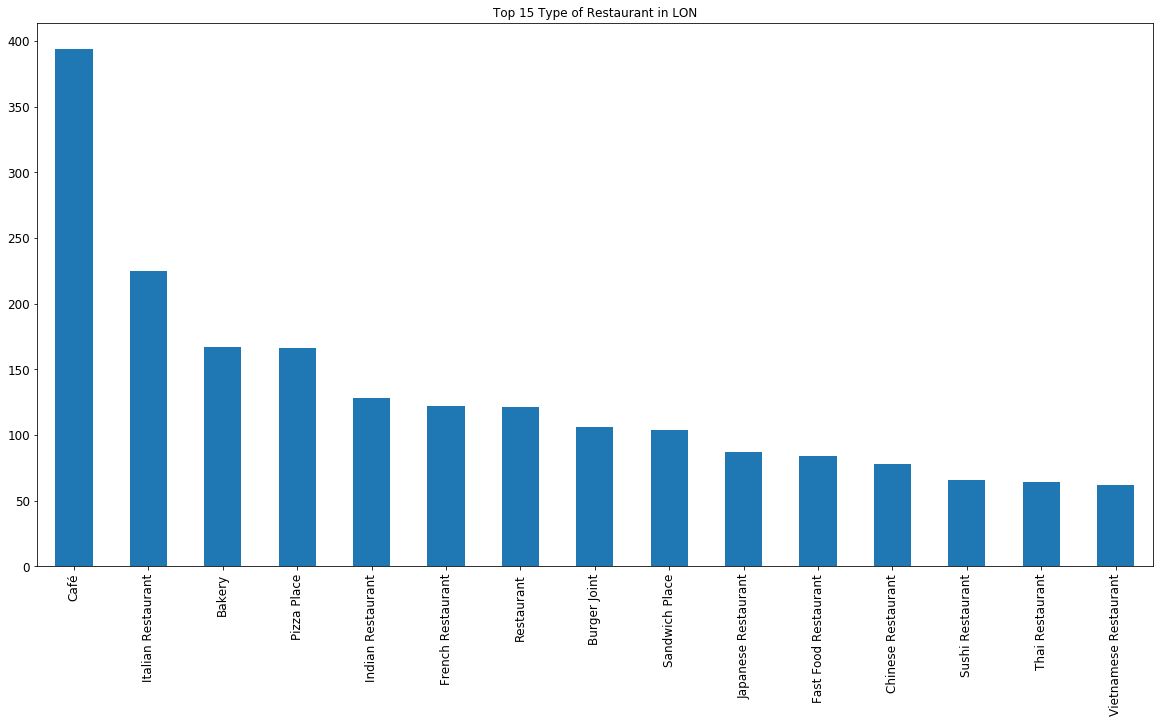

In [43]:
london_venues['Venue Category'].value_counts()[:15].plot(kind='bar', figsize=(20, 10), fontsize=12,
                                                        title='Top 15 Type of Restaurant in LON')

In [53]:
london_venues['Borough'].value_counts()
len(london_venues)

3223

As we and see from the bar chat Cafe out number other type of restaurant by almost 50%

In [57]:
london_venues['Borough'].value_counts()

Islington                                       100
City[10                                         100
Kensington and ChelseaHammersmith and Fulham    100
Brent, Harrow                                   100
City, Westminster                               100
Westminster                                     100
Dartford                                        100
City                                            100
Hammersmith and Fulham                          100
Islington & City                                100
Westminster[10                                  100
Camden                                          100
Kensington and Chelsea                          100
Camden and Islington                            100
Harrow, Brent                                   100
Camden[40                                        91
Tower Hamlets[40                                 85
Merton                                           83
Tower Hamlets                                    83
Lambeth, Wan

In [119]:
borough_rest_type_df = london_venues[['Borough','Venue Category']].groupby(['Borough', 'Venue Category'])
borough_rest_type_df.head()

,Borough,Venue Category
0,"Bexley, Greenwich",Bakery
1,"Bexley, Greenwich",Burger Joint
2,"Bexley, Greenwich",Café
3,"Bexley, Greenwich",Café
4,"Bexley, Greenwich",Fish & Chips Shop
5,"Bexley, Greenwich",Café
6,"Ealing, Hammersmith and Fulham",Creperie
7,"Ealing, Hammersmith and Fulham",Fast Food Restaurant
8,"Ealing, Hammersmith and Fulham",Bakery
9,"Ealing, Hammersmith and Fulham",Fast Food Restaurant


In [139]:
# Let's find how many restaurants each borough has and find the borough with the most restaurant, and explore each borough
borough_rest_type_count = borough_rest_type_df['Venue Category'].value_counts().to_frame(name='Count')
borough_rest_type_count

Count
Borough                                      Venue Category                  Venue Category                        
Barnet                                       Bakery                          Bakery                               2
                                             Breakfast Spot                  Breakfast Spot                       1
                                             Café                            Café                                 7
                                             Chinese Restaurant              Chinese Restaurant                   2
                                             Fast Food Restaurant            Fast Food Restaurant                 2
                                             Indian Restaurant               Indian Restaurant                    5
                                             Italian Restaurant              Italian Restaurant                   1
                                             Japanese Restaurant             Japanese Restaurant                  2
                                             Korean Restaurant               Korean Restaurant                    1
                                             Middle Eastern Restaurant       Middle Eastern Restaurant            2
                                             Persian Restaurant              Persian Restaurant                   1
                                             Pizza Place                     Pizza Place                          2
                                             Restaurant                      Restaurant                           3
                                             Sandwich Place                  Sandwich Place                       1
                                             Turkish Restaurant              Turkish Restaurant                   4
                                             Vietnamese Restaurant           Vietnamese Restaurant                1
Barnet, Brent, Camden                        Asian Restaurant                Asian Restaurant                     1
                                             Bagel Shop                      Bagel Shop                           1
                                             Bakery                          Bakery                               1
                                             Breakfast Spot                  Breakfast Spot                       2
                                             Café                            Café                                 1
                                             Chinese Restaurant              Chinese Restaurant                   2
                                             Fast Food Restaurant            Fast Food Restaurant                 5
                                             Italian Restaurant              Italian Restaurant                   1
                                             Pizza Place                     Pizza Place                          1
                                             Sandwich Place                  Sandwich Place                       1
Bexley                                       Bakery                          Bakery                               1
                                             Burger Joint                    Burger Joint                         1
                                             Café                            Café                                 3
                                             Fish & Chips Shop               Fish & Chips Shop                    1
Bexley,  Greenwich                           Bakery                          Bakery                               1
                                             Burger Joint                    Burger Joint                         1
                                             Café                            Café                                 3
                                             Fish 

In [121]:
borough_rest_type_count.describe()

,Count
count,1469.000000
mean,2.194010
std,2.101917
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,18.000000


In [137]:
borough_group['Location'] = df_read_london['Location']
borough_group_df = borough_group.groupby('Location').mean().reset_index()

In [138]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=0)
    
    model.fit(df_read_london('Location'))
    
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()